# Data Collection
---

In [1]:
# import necessary functions

import numpy as np
from numpy import datetime64 as dt64, timedelta64 as td64
import pickle

import sys, os
import shutil
import xarray as xr
import pandas as pd
from matplotlib import pyplot as plt
import cmocean.cm as cmo
import requests
import re
import datetime as dt
import seaborn as sns

from netCDF4 import Dataset, num2date, date2num 
from datetime import datetime, timedelta

from yodapy.datasources import OOI
ooi = OOI(cloud_source=True)

# Local application/library specific imports
#from golive_library import GoliveLibrary as g

from yodapy.utils.creds import set_credentials_file

(get-data-catalog) Request https://ooinet.oceanobservatories.org/api/m2m/12576/sensor/inv/toc failed: 401, UNAUTHORIZED
Exception in thread get-data-catalog:
Traceback (most recent call last):
  File "c:\users\derya\appdata\local\programs\python\python39\lib\threading.py", line 954, in _bootstrap_inner
    self.run()
  File "c:\users\derya\appdata\local\programs\python\python39\lib\threading.py", line 892, in run
    self._target(*self._args, **self._kwargs)
  File "c:\users\derya\appdata\local\programs\python\python39\lib\site-packages\yodapy\datasources\ooi\OOI.py", line 1224, in _get_data_catalog
    instruments_catalog = self._get_instruments_catalog()
  File "c:\users\derya\appdata\local\programs\python\python39\lib\site-packages\yodapy\datasources\ooi\OOI.py", line 1161, in _get_instruments_catalog
    instruments_json = toc_json["instruments"]
KeyError: 'instruments'


In [2]:
sns.set()

Website to get credentials: https://ooinet.oceanobservatories.org/

In [3]:
set_credentials_file(data_source='ooi', username='OOIAPI-xxx', token='TEMP-TOKEN-xxx')

Update save directory later

In [4]:
# enter your OOI API username and token, and directory where output .csv files are saved
API_USERNAME = 'OOIAPI-xxx'
API_TOKEN = 'TEMP-TOKEN-xxx'
save_dir = ''

Set up output and data directories - but if I'm using a ton of data, do I REALLY want to be saving all of it? It sounds like Don from OOI already has the data saved and organized as zarr files (can be opened using xarray) and it would save a lot of time to get them from him if I don't want to download years of data.

In [ ]:
# ooi.sites

In [ ]:
# ooi.instruments

The OOI literally has THOUSANDS of instruments!

In [ ]:
# Narrow selection by putting desired site reference designator into search
# 200m platform
# ooi.search('CE04OSPS')

In [ ]:
# ooi.instruments

Look at surface mooring data - looking for wind measurements

In [ ]:
# Narrow selection by putting desired site reference designator into search
# surface mooring
# ooi.search('CE04OSSM', instrument='pCO2 Air-Sea')

In [ ]:
# ooi.instruments

In [ ]:
# start_time = '2017-08-21T06:000'
# end_time = '2017-08-22T07:0000'    # the data file will include measurements close as possible to midnight on the morning of 2019-08-08 

In [ ]:
# ooi.request_data(begin_date=start_time, end_date=end_time)

In [ ]:
# # editing these
# %time req_asseet = ooi.request_data(begin_date=begin_date, end_date=end_date)
# filenamelist = ooi.to_xarray()

---
# Following along with the Endurance coastal upwelling notebook nugget

### Pull data 

Looking at just a small section of the data available:
* 200m platform at Oregon Offshore location (CE04)
* Use the CTD-O instrument, start with temperature
* March-June 2017 or 2018
* look at shallow profiler data later! 

Using this function written by lgarzio to request data from the OOI

In [5]:
def request_data(reference_designator, method, stream, start_date=None, end_date=None):
    site = reference_designator[:8]
    node = reference_designator[9:14]
    instrument = reference_designator[15:]

    # Create the request URL
    api_base_url = 'https://ooinet.oceanobservatories.org/api/m2m/12576/sensor/inv'
    data_request_url = '/'.join((api_base_url, site, node, instrument, method, stream))

    # All of the following are optional, but you should specify a date range
    params = {
        'format': 'application/netcdf',
        'include_provenance': 'true',
        'include_annotations': 'true'
    }
    if start_date:
        params['beginDT'] = start_date
    if end_date:
        params['endDT'] = end_date

    # Make the data request
    r = requests.get(data_request_url, params=params, auth=(API_USERNAME, API_TOKEN))
    data = r.json()

    # Return just the THREDDS URL
    return data['allURLs'][0]

Use the above function to get URLs according to your API tokens. Save these URLs so you don't have to request them again every time you open this notebook.

In [ ]:
# METBK_url = request_data('CE04OSSM-SBD11-06-METBKA000', 'recovered_host', 
#                          'metbk_a_dcl_instrument_recovered',
#                          '2017-01-01T00:00:00.000Z', '2017-12-31T12:00:00.000Z')
# print('METBK_url: %s' %METBK_url)

In [ ]:
# CTD_url = request_data('CE04OSPS-SF01B-2A-CTDPFA107', 'streamed', 'ctdpf_sbe43_sample',
#                         '2017-01-01T00:00:00.000Z', '2017-12-31T12:00:00.000Z')
# print('CTD_url: %s' %CTD_url)

In [ ]:
# METBK_url = request_data('CE04OSSM-SBD11-06-METBKA000', 'recovered_host', 
#                          'metbk_a_dcl_instrument_recovered',
#                          '2017-03-01T00:00:00.000Z', '2017-06-30T12:00:00.000Z')
# print('METBK_url: %s' %METBK_url)

In [ ]:
# CTD_url = request_data('CE04OSPS-SF01B-2A-CTDPFA107', 'streamed', 'ctdpf_sbe43_sample',
#                         '2017-03-01T00:00:00.000Z', '2017-06-30T12:00:00.000Z')
# print('CTD_url: %s' %CTD_url)

Saved the URLs below.

In [6]:
METBK_url = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/deryag@uw.edu/20210422T030752259Z-CE04OSSM-SBD11-06-METBKA000-recovered_host-metbk_a_dcl_instrument_recovered/catalog.html'

CTD_url = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/deryag@uw.edu/20210422T030848056Z-CE04OSPS-SF01B-2A-CTDPFA107-streamed-ctdpf_sbe43_sample/catalog.html'

### Load data files

This function does A LOT - will explain later

In [7]:
def get_data(url, variables, deployments=None):
    # Function to grab all data from specified directory
    tds_url = 'https://opendap.oceanobservatories.org/thredds/dodsC'
    dataset = requests.get(url).text
    ii = re.findall(r'href=[\'"]?([^\'" >]+)', dataset)
    # x = re.findall(r'(ooi/.*?.nc)', dataset)
    x = [y for y in ii if y.endswith('.nc')]
    for i in x:
        if i.endswith('.nc') == False:
            x.remove(i)
    for i in x:
        try:
            float(i[-4])
        except:
            x.remove(i)
    # dataset = [os.path.join(tds_url, i) for i in x]
    datasets = [os.path.join(tds_url, i.split('=')[-1]).replace("\\","/") for i in x]

    # remove deployments not in deployment list, if given
    if deployments is not None:
        deploy = ['deployment{:04d}'.format(j) for j in deployments]
        datasets = [k for k in datasets if k.split('/')[-1].split('_')[0] in deploy]

    # remove collocated data files if necessary
    catalog_rms = url.split('/')[-2][20:]
    selected_datasets = []
    for d in datasets:
        if catalog_rms == d.split('/')[-1].split('_20')[0][15:]:
            selected_datasets.append(d)

    # create a dictionary to populate with data from the selected datasets
    data_dict = {'time': np.array([], dtype='datetime64[ns]')}
    unit_dict = {}
    for v in variables:
        data_dict.update({v: np.array([])})
        unit_dict.update({v: []})
    print('Appending data from files')

    for sd in selected_datasets:
        url_with_fillmismatch = f'{sd}#fillmismatch'
        ds = xr.open_dataset(url_with_fillmismatch, mask_and_scale=False)
        data_dict['time'] = np.append(data_dict['time'], ds['time'].values)
        for var in variables:
            data_dict[var] = np.append(data_dict[var], ds[var].values)
            units = ds[var].units
            if units not in unit_dict[var]:
                unit_dict[var].append(units)

    # convert dictionary to a dataframe
    df = pd.DataFrame(data_dict)
    df.sort_values(by=['time'], inplace=True)  # make sure the timestamps are in ascending order

    return df, unit_dict

Time to actually GET the data! Print a `.head()` of each dataset to make sure the data was successfully pulled.

In [8]:
# Specify the variable(s) of interest and get the data for the three datasets
CTD_var = ['seawater_pressure', 'density', 'practical_salinity', 'seawater_temperature', 'corrected_dissolved_oxygen', 
           'lat', 'lon']
METBK_var = ['sea_surface_temperature', 'met_windavg_mag_corr_east', 'met_windavg_mag_corr_north']

CTD_data, CTD_units = get_data(CTD_url, CTD_var)
METBK_data, METBK_units = get_data(METBK_url, METBK_var)
print(CTD_units)
print(METBK_units)

CTD_data_copy = CTD_data
METBK_data_copy = METBK_data

Appending data from files
Appending data from files
{'seawater_pressure': ['dbar'], 'practical_salinity': ['1'], 'seawater_temperature': ['ºC'], 'corrected_dissolved_oxygen': ['µmol kg-1'], 'lat': ['degrees_north'], 'lon': ['degrees_east']}
{'sea_surface_temperature': ['ºC'], 'met_windavg_mag_corr_east': ['m s-1'], 'met_windavg_mag_corr_north': ['m s-1']}


In [9]:
CTD_data = CTD_data_copy
METBK_data = METBK_data_copy

In [10]:
print(CTD_data.shape)
print(METBK_data.shape)

(21517483, 7)
(485137, 4)


In [11]:
CTD_data.head()

,time,seawater_pressure,practical_salinity,seawater_temperature,corrected_dissolved_oxygen,lat,lon
14955101,2017-01-01 00:00:00.317937152,200.479041,33.886699,7.785772,106.590066,44.37415,-124.95648
14955102,2017-01-01 00:00:01.318152192,200.473701,33.886692,7.786201,106.566439,44.37415,-124.95648
14955103,2017-01-01 00:00:02.318157312,200.467264,33.886432,7.786262,106.633814,44.37415,-124.95648
14955104,2017-01-01 00:00:03.317954560,200.465142,33.886519,7.785895,106.511052,44.37415,-124.95648
14955105,2017-01-01 00:00:04.318168576,200.466196,33.886425,7.785711,106.702620,44.37415,-124.95648


In [12]:
METBK_data.head()

,time,sea_surface_temperature,met_windavg_mag_corr_east,met_windavg_mag_corr_north
325934,2017-01-01 00:00:30.432000000,11.273,4.095093,-7.196688
325935,2017-01-01 00:01:37.298999808,11.268,6.134961,-5.290137
325936,2017-01-01 00:02:41.522000384,11.267,4.501072,-4.933199
325937,2017-01-01 00:03:46.300000256,11.267,3.296377,-4.787901
325938,2017-01-01 00:04:50.525000192,11.278,4.516634,-4.688541


Yay! If one of the above printouts is empty try rerunning the cell where you got the data.

There's a bunch of plotting for the glider data that I'm skipping because I'm more interested in the platform data for this project. Will need to edit the code above so I'm not pulling data that I don't end up using.

Not sure I need to remove zeros but it's here just in case.

In [13]:
# this function can only be used if the expected values are always >0
def remove_zeros(df, variables):
    cnames = []
    for v in variables:
        if v not in ['lat', 'lon']:
            cname = v + '_ind'
            cnames.append(cname)
            df[cname] = df[v] > 0.00
    for cn in cnames:
        df = df.loc[df[cn] == True]
    df = df.drop(columns=cnames)
    return df

In [ ]:
# CTD_data = remove_zeros(CTD_data, CTD_var)
# METBK_data = remove_zeros(METBK_data, METBK_var)

### Quick EDA
Just check for nulls and do a `.describe()` for now.

In [14]:
METBK_data.shape

(485137, 4)

In [15]:
METBK_data.describe()

,sea_surface_temperature,met_windavg_mag_corr_east,met_windavg_mag_corr_north
count,485137.000000,4.671560e+05,4.671560e+05
mean,12.504472,-1.806753e+05,-1.031858e+05
std,1.816724,1.478567e+06,8.444168e+05
min,9.854000,-1.228062e+07,-7.013654e+06
25%,10.622000,-8.175190e-01,-5.188641e+00
50%,12.163000,8.225444e-01,-1.676100e+00
75%,14.158000,2.683002e+00,3.312628e+00
max,17.580999,1.502310e+01,2.124346e+01


In [16]:
METBK_data.isna().sum()

time                              0
sea_surface_temperature           0
met_windavg_mag_corr_east     17981
met_windavg_mag_corr_north    17981
dtype: int64

In [17]:
CTD_data.describe()

,seawater_pressure,practical_salinity,seawater_temperature,corrected_dissolved_oxygen,lat,lon
count,2.151748e+07,2.151748e+07,2.151748e+07,2.151748e+07,2.151748e+07,2.151748e+07
mean,1.892278e+02,3.382338e+01,7.923279e+00,1.032202e+02,4.437415e+01,-1.249565e+02
std,3.956323e+01,2.838685e-01,7.240315e-01,2.854860e+01,2.273737e-12,5.087486e-12
min,1.355533e+01,2.668256e+01,6.647794e+00,3.493388e+01,4.437415e+01,-1.249565e+02
25%,2.026819e+02,3.384952e+01,7.368913e+00,8.760923e+01,4.437415e+01,-1.249565e+02
50%,2.037541e+02,3.390711e+01,7.839711e+00,1.002137e+02,4.437415e+01,-1.249565e+02
75%,2.044697e+02,3.394010e+01,8.267647e+00,1.125449e+02,4.437415e+01,-1.249565e+02
max,2.906436e+02,3.402038e+01,1.545517e+01,3.261326e+02,4.437415e+01,-1.249565e+02


In [18]:
CTD_data.shape

(21517483, 7)

In [19]:
CTD_data.isna().sum()

time                          0
seawater_pressure             0
practical_salinity            0
seawater_temperature          0
corrected_dissolved_oxygen    0
lat                           0
lon                           0
dtype: int64

No nulls because they've been filled with designated values (see data URLs and OPeNDAP server info to see what the fill value is for each individual variable).

In [24]:
CTD_data

,time,seawater_pressure,practical_salinity,seawater_temperature,corrected_dissolved_oxygen,lat,lon
14955101,2017-01-01 00:00:00.317937152,200.479041,33.886699,7.785772,106.590066,44.37415,-124.95648
14955102,2017-01-01 00:00:01.318152192,200.473701,33.886692,7.786201,106.566439,44.37415,-124.95648
14955103,2017-01-01 00:00:02.318157312,200.467264,33.886432,7.786262,106.633814,44.37415,-124.95648
14955104,2017-01-01 00:00:03.317954560,200.465142,33.886519,7.785895,106.511052,44.37415,-124.95648
14955105,2017-01-01 00:00:04.318168576,200.466196,33.886425,7.785711,106.702620,44.37415,-124.95648
...,...,...,...,...,...,...,...
3811651,2017-09-16 12:13:36.480951808,55.887428,33.515015,9.740724,174.247648,44.37415,-124.95648
3811652,2017-09-16 12:13:37.480647680,55.495146,33.513691,9.733299,174.247264,44.37415,-124.95648
3811653,2017-09-16 12:13:38.480967680,55.449183,33.524510,9.725553,174.128022,44.37415,-124.95648
3811654,2017-09-16 12:13:39.480977408,55.550728,33.524760,9.729361,174.092489,44.37415,-124.95648


In [25]:
METBK_data

,time,sea_surface_temperature,met_windavg_mag_corr_east,met_windavg_mag_corr_north
325934,2017-01-01 00:00:30.432000000,11.273,4.095093e+00,-7.196688e+00
325935,2017-01-01 00:01:37.298999808,11.268,6.134961e+00,-5.290137e+00
325936,2017-01-01 00:02:41.522000384,11.267,4.501072e+00,-4.933199e+00
325937,2017-01-01 00:03:46.300000256,11.267,3.296377e+00,-4.787901e+00
325938,2017-01-01 00:04:50.525000192,11.278,4.516634e+00,-4.688541e+00
...,...,...,...,...
73128,2017-12-01 18:28:40.451000320,12.053,-1.228042e+07,-7.013654e+06
73129,2017-12-01 18:29:44.697999872,12.053,-1.228042e+07,-7.013654e+06
73130,2017-12-01 18:30:16.942000128,12.052,-1.228042e+07,-7.013654e+06
73131,2017-12-01 18:31:21.691999744,12.052,-1.228042e+07,-7.013654e+06


---
# METBK data

Quick conversion from annoying timestamp to proper datetime for easier slicing later! 

In [22]:
METBK_data['time']

325934   2017-01-01 00:00:30.432000000
325935   2017-01-01 00:01:37.298999808
325936   2017-01-01 00:02:41.522000384
325937   2017-01-01 00:03:46.300000256
325938   2017-01-01 00:04:50.525000192
                      ...             
73128    2017-12-01 18:28:40.451000320
73129    2017-12-01 18:29:44.697999872
73130    2017-12-01 18:30:16.942000128
73131    2017-12-01 18:31:21.691999744
73132    2017-12-01 18:32:26.453000192
Name: time, Length: 485137, dtype: datetime64[ns]

In [23]:
METBK_data['time'].apply(lambda x: x.strftime('%Y-%m-%d %H:%M:%S'))

325934    2017-01-01 00:00:30
325935    2017-01-01 00:01:37
325936    2017-01-01 00:02:41
325937    2017-01-01 00:03:46
325938    2017-01-01 00:04:50
                 ...         
73128     2017-12-01 18:28:40
73129     2017-12-01 18:29:44
73130     2017-12-01 18:30:16
73131     2017-12-01 18:31:21
73132     2017-12-01 18:32:26
Name: time, Length: 485137, dtype: object

The last couple weeks of this data have some weirdness, slice them out for now!

In [36]:
mask = (METBK_data['time'][:] > '2017-01-01') & (METBK_data['time'] <= '2017-11-15')
METBK_data = METBK_data.loc[mask]

In [37]:
METBK_data['time']

325934   2017-01-01 00:00:30.432000000
325935   2017-01-01 00:01:37.298999808
325936   2017-01-01 00:02:41.522000384
325937   2017-01-01 00:03:46.300000256
325938   2017-01-01 00:04:50.525000192
                      ...             
48975    2017-11-14 23:55:44.732999680
48976    2017-11-14 23:56:48.960999936
48977    2017-11-14 23:57:53.864999936
48978    2017-11-14 23:58:58.362999808
48979    2017-11-14 23:59:32.812000256
Name: time, Length: 460984, dtype: datetime64[ns]

In [38]:
METBK_data

,time,sea_surface_temperature,met_windavg_mag_corr_east,met_windavg_mag_corr_north
325934,2017-01-01 00:00:30.432000000,11.273,4.095093,-7.196688
325935,2017-01-01 00:01:37.298999808,11.268,6.134961,-5.290137
325936,2017-01-01 00:02:41.522000384,11.267,4.501072,-4.933199
325937,2017-01-01 00:03:46.300000256,11.267,3.296377,-4.787901
325938,2017-01-01 00:04:50.525000192,11.278,4.516634,-4.688541
...,...,...,...,...
48975,2017-11-14 23:55:44.732999680,11.947,NaN,NaN
48976,2017-11-14 23:56:48.960999936,11.948,NaN,NaN
48977,2017-11-14 23:57:53.864999936,11.944,NaN,NaN
48978,2017-11-14 23:58:58.362999808,11.941,NaN,NaN


In [39]:
# import numpy.ma as ma
# mask = ma.masked_less(METBK_data['met_windavg_mag_corr_north'], 0)

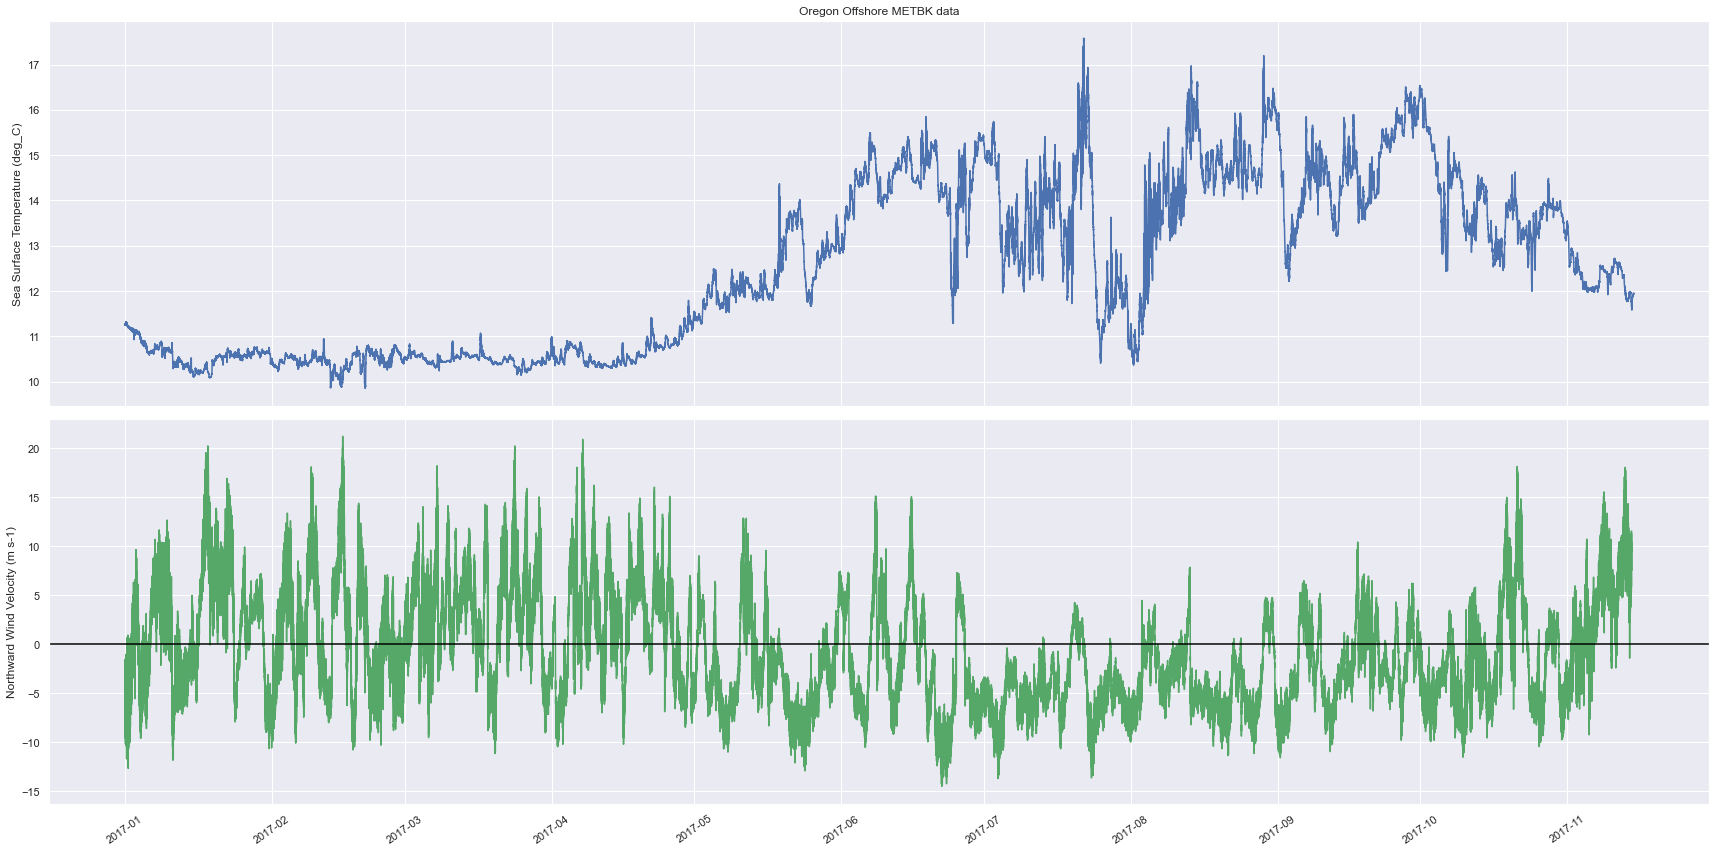

In [40]:
fig, (ax1, ax3) = plt.subplots(2,1, sharex=True, figsize = (24, 12)) # removed ax2
ax1.plot(METBK_data['time'], METBK_data['sea_surface_temperature'], 'b')
ax1.set_xlabel('')
ax1.set_ylabel('Sea Surface Temperature (deg_C)')
ax1.set_title('Oregon Offshore METBK data')

# ax2.plot(METBK_data['time'], METBK_data['met_windavg_mag_corr_east'], 'c')
# ax2.set_xlabel('')
# ax2.set_ylabel('Eastward Wind Velocity ({})'.format(METBK_units['met_windavg_mag_corr_east'][0]))

ax3.plot(METBK_data['time'], METBK_data['met_windavg_mag_corr_north'], 'g')
ax3.set_xlabel('')
ax3.set_ylabel('Northward Wind Velocity ({})'.format(METBK_units['met_windavg_mag_corr_north'][0]))
ax3.axhline(y=0, ls='-', c='black') # add horizontal line at 0

plt.xticks(rotation=35);
plt.tight_layout()
plt.savefig('METBK_SST_NWind.png')

In [42]:
METBK_hourly = METBK_data.resample('H', on='time').mean().dropna(how='all').reset_index()
#METBK_hourly.head()
METBK_daily = METBK_data.resample('D', on='time').mean().dropna(how='all').reset_index()
METBK_daily.head()

,time,sea_surface_temperature,met_windavg_mag_corr_east,met_windavg_mag_corr_north
0,2017-01-01,11.247412,6.413056,-5.371468
1,2017-01-02,11.149430,-1.148830,-1.207261
2,2017-01-03,11.089363,-5.203772,2.533484
3,2017-01-04,10.926763,-6.222477,-4.027738
4,2017-01-05,10.756387,-6.911579,-3.048631


In [43]:
# calculate the percentage of time during this time range that winds are blowing towards the south
north_winds = np.array(METBK_hourly['met_windavg_mag_corr_north'])
upwelling_percentage = len(north_winds[north_winds < 0]) / len(north_winds) * 100
print('{}%'.format(round(upwelling_percentage)))

58%


In [129]:
METBK_units

{'sea_surface_temperature': ['ºC'],
 'met_windavg_mag_corr_east': ['m s-1'],
 'met_windavg_mag_corr_north': ['m s-1']}

In [44]:
# rename the columns and add units
METBK_hourly = METBK_hourly.rename(columns={'sea_surface_temperature': 'Sea Surface Temperature (deg_C)',
                                            'met_windavg_mag_corr_east': 'Eastward Wind Velocity ({})'.format(METBK_units['met_windavg_mag_corr_east'][0]), 
                                            'met_windavg_mag_corr_north': 'Northward Wind Velocity ({})'.format(METBK_units['met_windavg_mag_corr_north'][0])})
METBK_daily = METBK_daily.rename(columns={'sea_surface_temperature': 'Sea Surface Temperature (deg_C)',
                                            'met_windavg_mag_corr_east': 'Eastward Wind Velocity ({})'.format(METBK_units['met_windavg_mag_corr_east'][0]), 
                                            'met_windavg_mag_corr_north': 'Northward Wind Velocity ({})'.format(METBK_units['met_windavg_mag_corr_north'][0])})
# Grab times of interest
mask = (METBK_hourly['time'][:] > '2017-05-01') & (METBK_hourly['time'] <= '2017-08-01')
METBK_summer_data = METBK_hourly.loc[mask]

METBK_summer_data.head()

,time,Sea Surface Temperature (deg_C),Eastward Wind Velocity (m s-1),Northward Wind Velocity (m s-1)
2881,2017-05-01 01:00:00,11.501148,0.157822,-5.022655
2882,2017-05-01 02:00:00,11.473915,-0.225458,-5.002200
2883,2017-05-01 03:00:00,11.422934,-0.538107,-4.982206
2884,2017-05-01 04:00:00,11.375763,-0.197684,-4.570065
2885,2017-05-01 05:00:00,11.417852,-0.316350,-4.869859


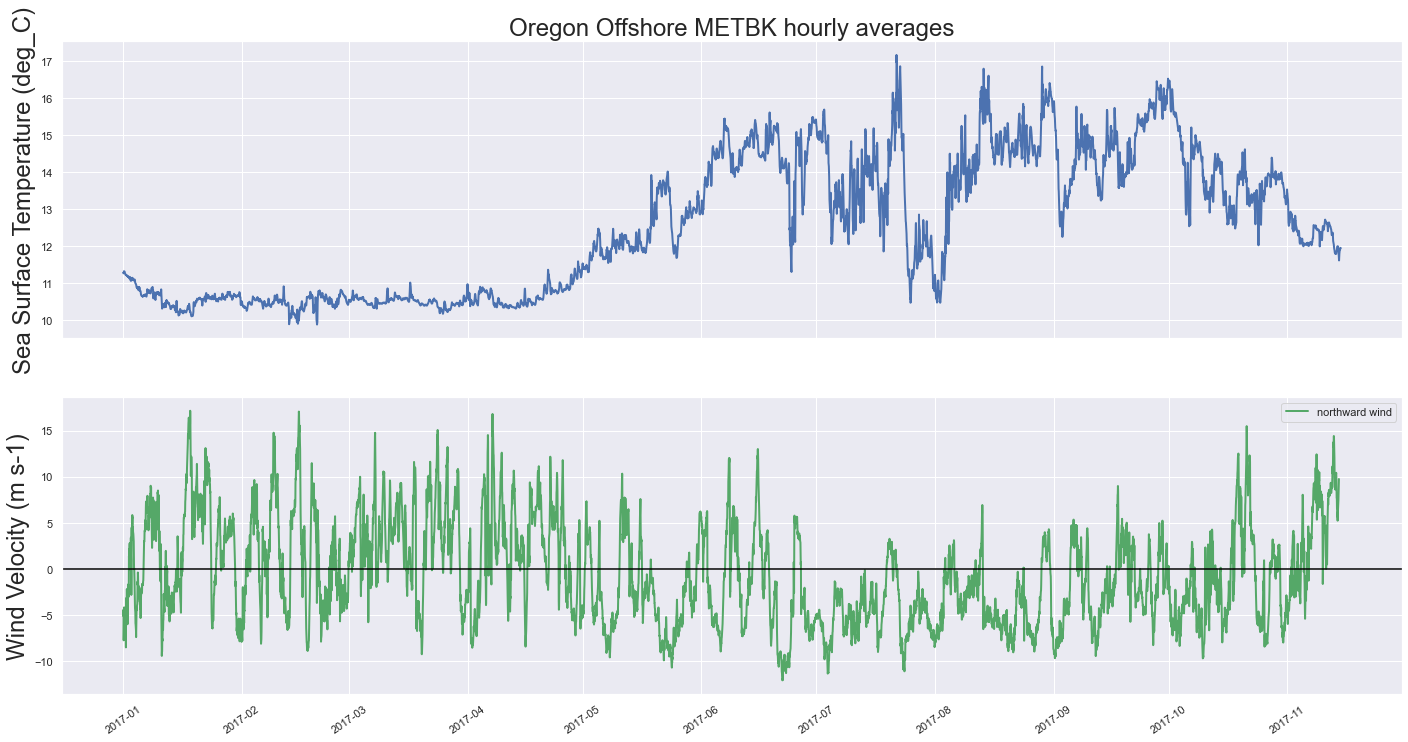

In [45]:
# Plot hourly-averaged METBK data
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(24, 12))
ax1.plot(METBK_hourly['time'], METBK_hourly['Sea Surface Temperature (deg_C)'], 'b', linewidth=2)
ax1.set_xlabel('')
ax1.set_ylabel('Sea Surface Temperature (deg_C)', size=24)
ax1.set_title('Oregon Offshore METBK hourly averages', size=24)

#ax2.plot(METBK_hourly['time'], METBK_hourly['Eastward Wind Velocity (m s-1)'], 'c', label='eastward wind')
ax2.plot(METBK_hourly['time'], METBK_hourly['Northward Wind Velocity (m s-1)'], 'g', label='northward wind', linewidth=2)
ax2.set_ylabel('Wind Velocity ({})'.format(METBK_units['met_windavg_mag_corr_north'][0]), size=24)
ax2.legend()
ax2.axhline(y=0, ls='-', c='black') # add horizontal line at 0

plt.xticks(rotation=35);

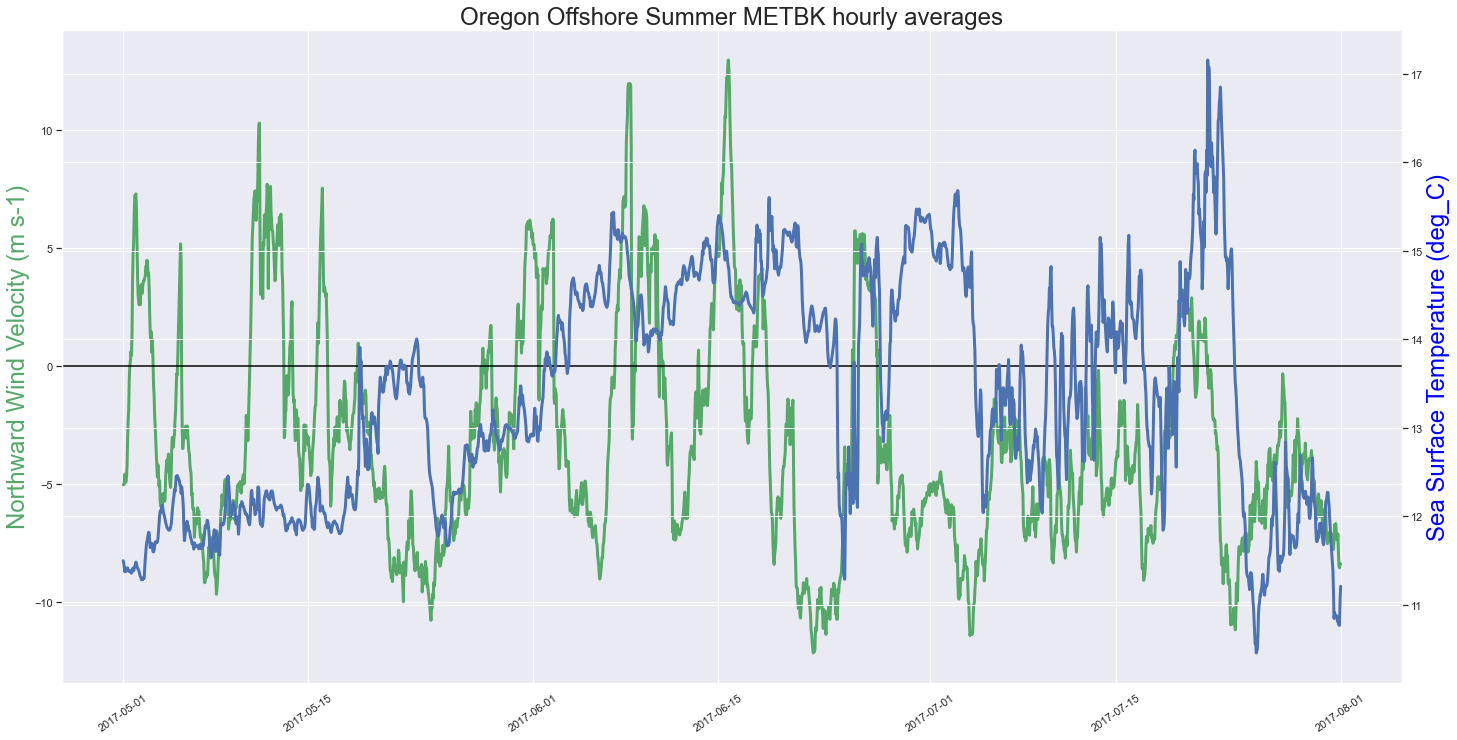

In [46]:
fig, ax = plt.subplots(figsize=(24, 12))
ax.plot(METBK_summer_data['time'], METBK_summer_data['Northward Wind Velocity (m s-1)'], 'g', linewidth=3)
ax.set_ylabel('Northward Wind Velocity (m s-1)', color='g', size=24)
plt.xticks(rotation=35)

ax2 = ax.twinx()  # instantiate a second axis that shares the same x-axis
ax2.plot(METBK_summer_data['time'], METBK_summer_data['Sea Surface Temperature (deg_C)'], 'b', linewidth=3)
ax2.set_ylabel('Sea Surface Temperature (deg_C)', color='blue', size=24)

ax.axhline(y=0, ls='-', c='black') # add horizontal line at 0
ax.set_title('Oregon Offshore Summer METBK hourly averages', size=24);

---
# CTD data
Time to look at the CTD data collected by the shallow profiler! These go up an down in the water column (top 200m) 9 times a day. Good example plots of profiler paths and change in temp and salinity with depth in the notebook of [yodapy example plots](https://github.com/dgumustel/yodapy/blob/master/examples/yodapy_example_plots.ipynb).


In [48]:
CTD_minutes = CTD_data.resample('T', on='time').mean().dropna(how='all').reset_index()
METBK_minutes = METBK_data.resample('T', on='time').mean().dropna(how='all').reset_index()
#CTD_minutes.head()

CTD_hourly = CTD_data.resample('H', on='time').mean().dropna(how='all').reset_index()
#METBK_hourly.head()
CTD_daily = CTD_data.resample('D', on='time').mean().dropna(how='all').reset_index()
#CTD_daily.head()

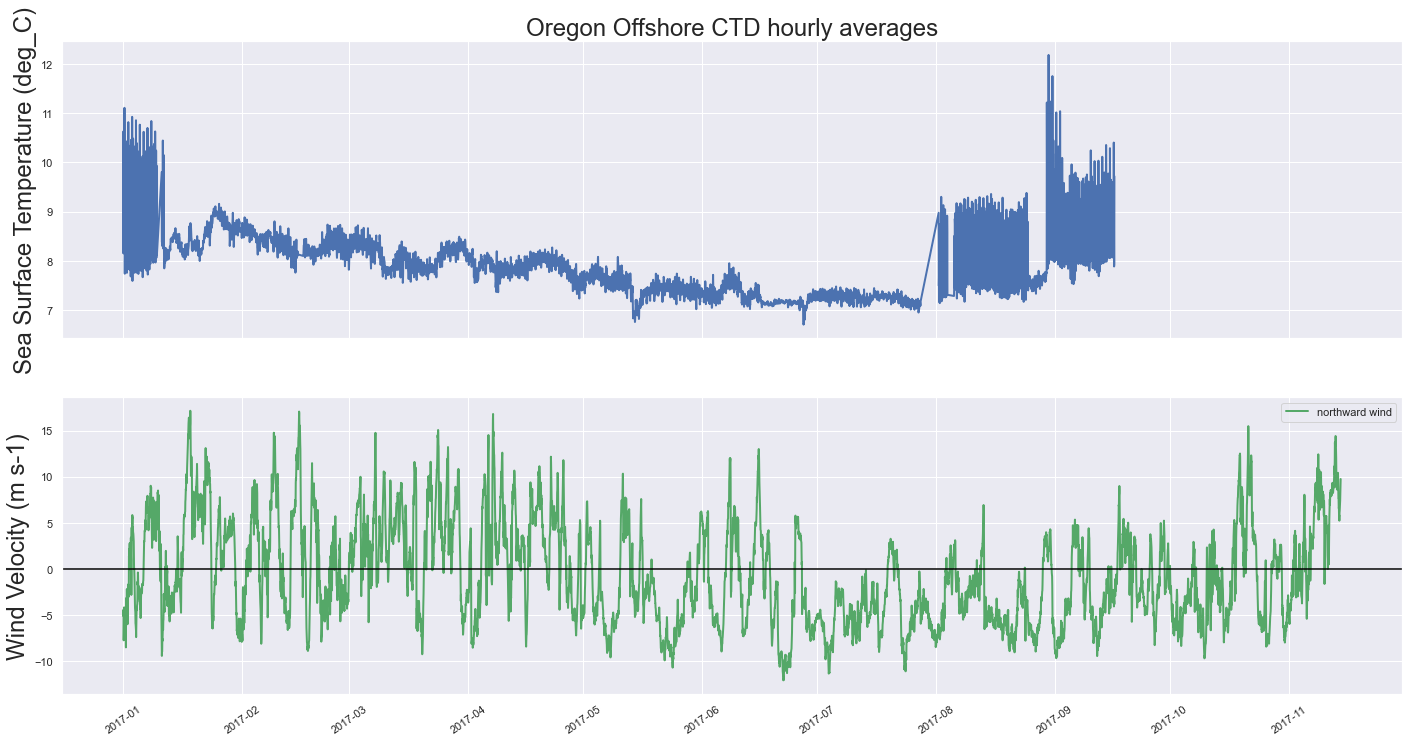

In [49]:
# Plot hourly-averaged METBK data
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(24, 12))
ax1.plot(CTD_hourly['time'], CTD_hourly['seawater_temperature'], 'b', linewidth=2)
ax1.set_xlabel('')
ax1.set_ylabel('Sea Surface Temperature (deg_C)', size=24)
ax1.set_title('Oregon Offshore CTD hourly averages', size=24)

#ax2.plot(METBK_hourly['time'], METBK_hourly['Eastward Wind Velocity (m s-1)'], 'c', label='eastward wind')
ax2.plot(METBK_hourly['time'], METBK_hourly['Northward Wind Velocity (m s-1)'], 'g', label='northward wind', linewidth=2)
ax2.set_ylabel('Wind Velocity ({})'.format(METBK_units['met_windavg_mag_corr_north'][0]), size=24)
ax2.legend()
ax2.axhline(y=0, ls='-', c='black') # add horizontal line at 0

plt.xticks(rotation=35);

In [50]:
mask = (CTD_data['time'][:] > '2017-08-20') & (CTD_data['time'] <= '2017-08-25')
CTD_week = CTD_data.loc[mask]

CTD_week.shape

(431988, 7)

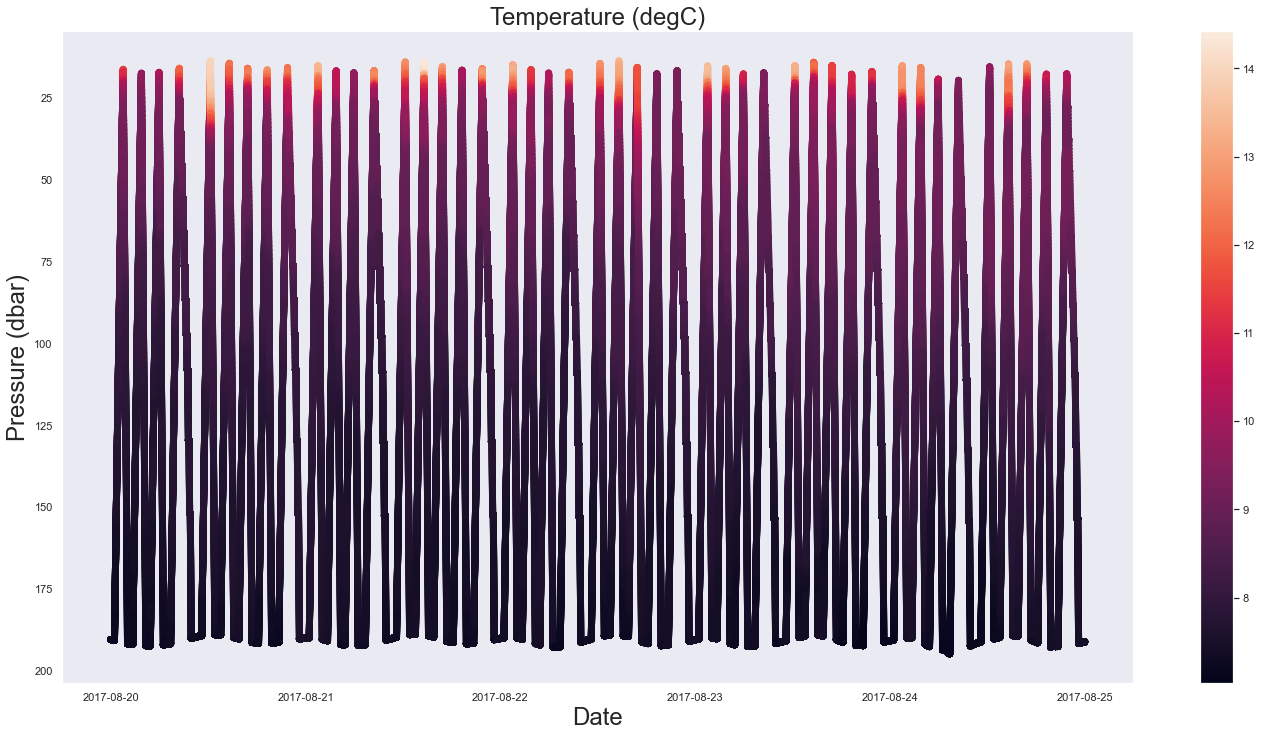

In [89]:
# Now, more complete colored scatter plot, with data plotted
# on a depth vs. time axis.

fig, ax = plt.subplots(figsize=(24, 12))

# plot temp and salinity curtain plots
ax.invert_yaxis()
ax.grid()
#ax1.set_xlim(CTD_data['time'],CTD_data['time'])
sc = ax.scatter(CTD_week['time'],CTD_week['seawater_pressure'],c=CTD_week['seawater_temperature'])
ax.set_xlabel('Date', size=24)
ax.set_ylabel('Pressure (dbar)', size=24)
ax.set_title('Temperature (degC)', size=24)
cb = fig.colorbar(sc,ax=ax)

plt.savefig('CTD_profiler_week.png')

Notice how wavy the bottom of this pattern is? Those are probably the daily tide cycle!!

In [100]:
CTD_week

,time,seawater_pressure,practical_salinity,seawater_temperature,corrected_dissolved_oxygen,lat,lon
1436284,2017-08-20 00:00:00.031634432,190.437263,33.968276,7.208273,77.760241,44.37415,-124.95648
1436285,2017-08-20 00:00:01.031017472,190.436193,33.967962,7.208453,77.760076,44.37415,-124.95648
1436286,2017-08-20 00:00:02.031339008,190.437286,33.967854,7.208632,77.735604,44.37415,-124.95648
1436287,2017-08-20 00:00:03.031242240,190.438379,33.967508,7.208632,77.772129,44.37415,-124.95648
1436288,2017-08-20 00:00:04.030938112,190.439449,33.967828,7.208094,77.772958,44.37415,-124.95648
...,...,...,...,...,...,...,...
1868267,2017-08-24 23:59:55.546240512,191.131478,33.968504,7.414319,81.144326,44.37415,-124.95648
1868268,2017-08-24 23:59:56.547081216,191.131478,33.968455,7.414439,81.180264,44.37415,-124.95648
1868269,2017-08-24 23:59:57.546879488,191.132548,33.968171,7.414800,81.131559,44.37415,-124.95648
1868270,2017-08-24 23:59:58.546262016,191.132571,33.968299,7.414740,81.023176,44.37415,-124.95648


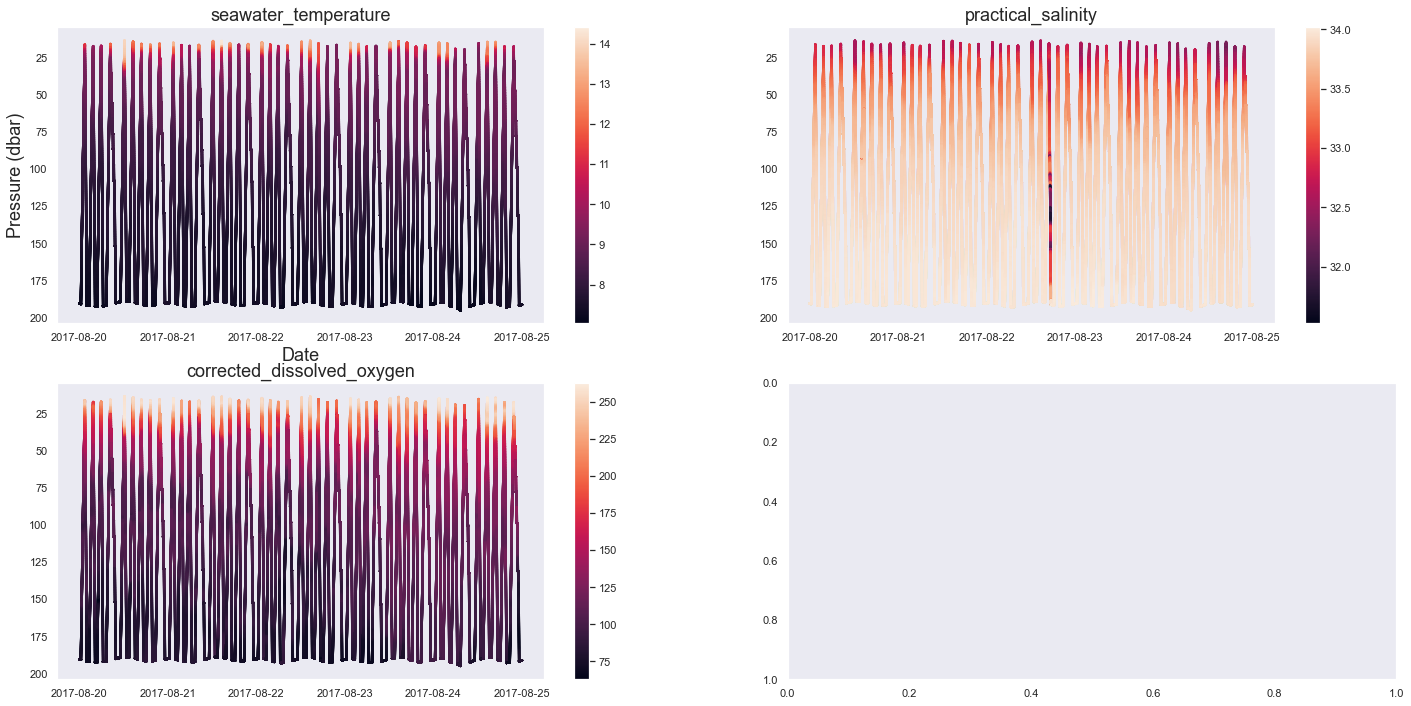

In [102]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(24, 12))

for ax in [ax1, ax2, ax3, ax4]:
    ax.invert_yaxis()
    ax.grid()
    ax1.set_xlabel('Date', size=18)
    ax1.set_ylabel('Pressure (dbar)', size=18)

#ax1.set_xlim(CTD_data['time'],CTD_data['time'])
sc = ax1.scatter(CTD_week['time'],CTD_week['seawater_pressure'],c=CTD_week['seawater_temperature'], s=2)
cb = fig.colorbar(sc,ax=ax1)
ax1.set_title('seawater_temperature', size=18)

sc = ax2.scatter(CTD_week['time'],CTD_week['seawater_pressure'],c=CTD_week['practical_salinity'], s=2)
cb = fig.colorbar(sc,ax=ax2)
ax2.set_title('practical_salinity', size=18)

sc = ax3.scatter(CTD_week['time'],CTD_week['seawater_pressure'],c=CTD_week['corrected_dissolved_oxygen'], s=2)
cb = fig.colorbar(sc,ax=ax3)
ax3.set_title('corrected_dissolved_oxygen', size=18)

# sc = ax4.scatter(CTD_week['time'],CTD_week['seawater_pressure'],c=CTD_week['seawater_temperature'], s=2)
# cb = fig.colorbar(sc,ax=ax4)
# ax4.set_title('density', size=18)



plt.savefig('CTD_profiler_multi.png')

In [52]:
CTD_data.shape

(21517483, 7)

In [53]:
# Grab times of interest
mask = (CTD_data['time'][:] > '2017-05-01') & (CTD_data['time'] <= '2017-06-30')
CTD_summer = CTD_data.loc[mask]

CTD_summer

,time,seawater_pressure,practical_salinity,seawater_temperature,corrected_dissolved_oxygen,lat,lon
11932676,2017-05-01 00:00:00.148581888,204.771057,33.921239,7.584159,96.869855,44.37415,-124.95648
11932677,2017-05-01 00:00:01.148379136,204.771086,33.920807,7.584463,96.880750,44.37415,-124.95648
11932678,2017-05-01 00:00:02.148490752,204.771100,33.921069,7.583915,96.859247,44.37415,-124.95648
11932679,2017-05-01 00:00:03.148599296,204.769007,33.921612,7.583428,96.780907,44.37415,-124.95648
11932680,2017-05-01 00:00:04.148918272,204.763681,33.921530,7.583307,96.928002,44.37415,-124.95648
...,...,...,...,...,...,...,...
5971565,2017-06-29 23:59:55.060705792,204.932333,33.935600,7.344093,65.448449,44.37415,-124.95648
5971566,2017-06-29 23:59:56.059877376,204.930182,33.936170,7.343790,65.403202,44.37415,-124.95648
5971567,2017-06-29 23:59:57.059884544,204.921623,33.935960,7.343730,65.426042,44.37415,-124.95648
5971568,2017-06-29 23:59:58.059892736,204.917365,33.936003,7.343549,65.414913,44.37415,-124.95648


In [56]:
mask = (CTD_minutes['time'][:] > '2017-05-01') & (CTD_minutes['time'] <= '2017-06-30')
CTD_summer_minutes = CTD_minutes.loc[mask]

CTD_summer_minutes.shape

(86384, 7)

In [57]:
mask = (METBK_minutes['time'][:] > '2017-05-01') & (METBK_minutes['time'] <= '2017-06-30')
METBK_summer_minutes = METBK_minutes.loc[mask]

METBK_summer_minutes.shape

(81224, 4)

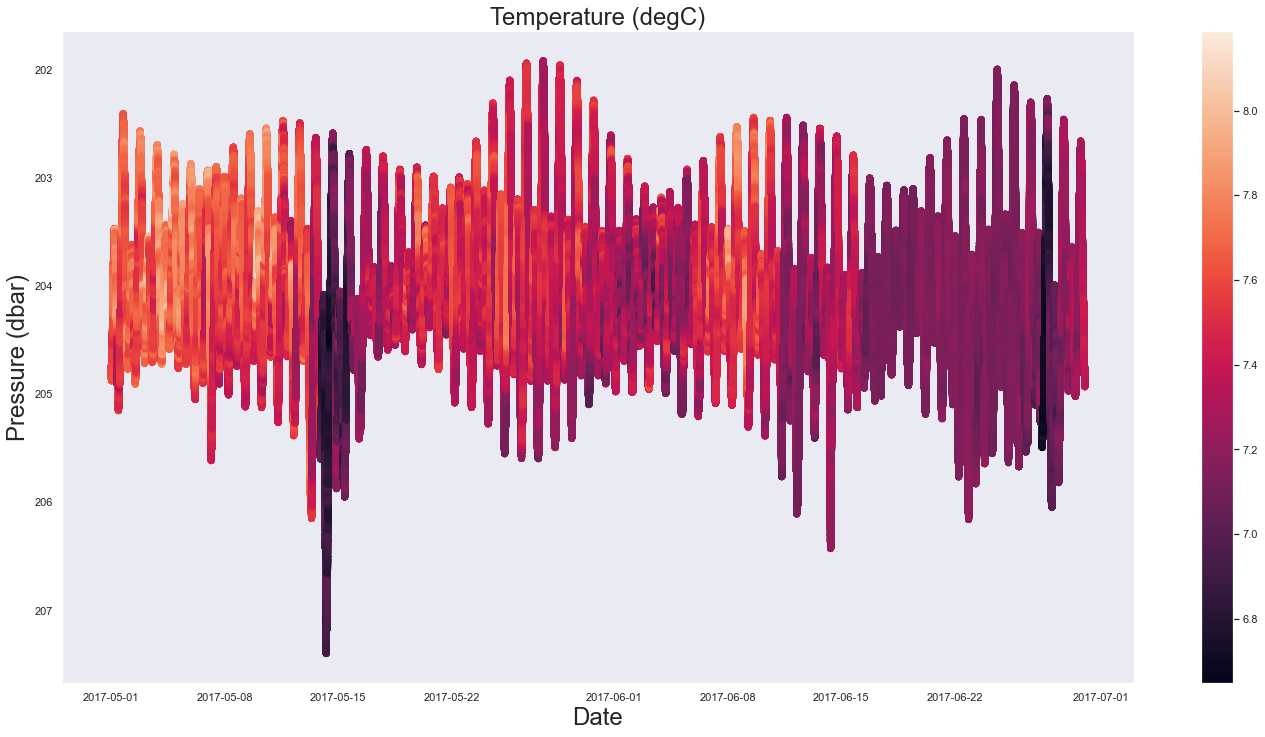

In [58]:
# Now, more complete colored scatter plot, with data plotted
# on a depth vs. time axis.
# source: https://github.com/dgumustel/yodapy/blob/master/examples/yodapy_example_plots.ipynb

fig, ax = plt.subplots(figsize=(24, 12))

# plot temp and salinity curtain plots
ax.invert_yaxis()
ax.grid()
#ax1.set_xlim(CTD_data['time'],CTD_data['time'])
sc = ax.scatter(CTD_summer['time'],CTD_summer['seawater_pressure'],c=CTD_summer['seawater_temperature'])
ax.set_xlabel('Date', size=24)
ax.set_ylabel('Pressure (dbar)', size=24)
ax.set_title('Temperature (degC)', size=24)
cb = fig.colorbar(sc,ax=ax)

plt.savefig('CTD_profiler_temperature.png')

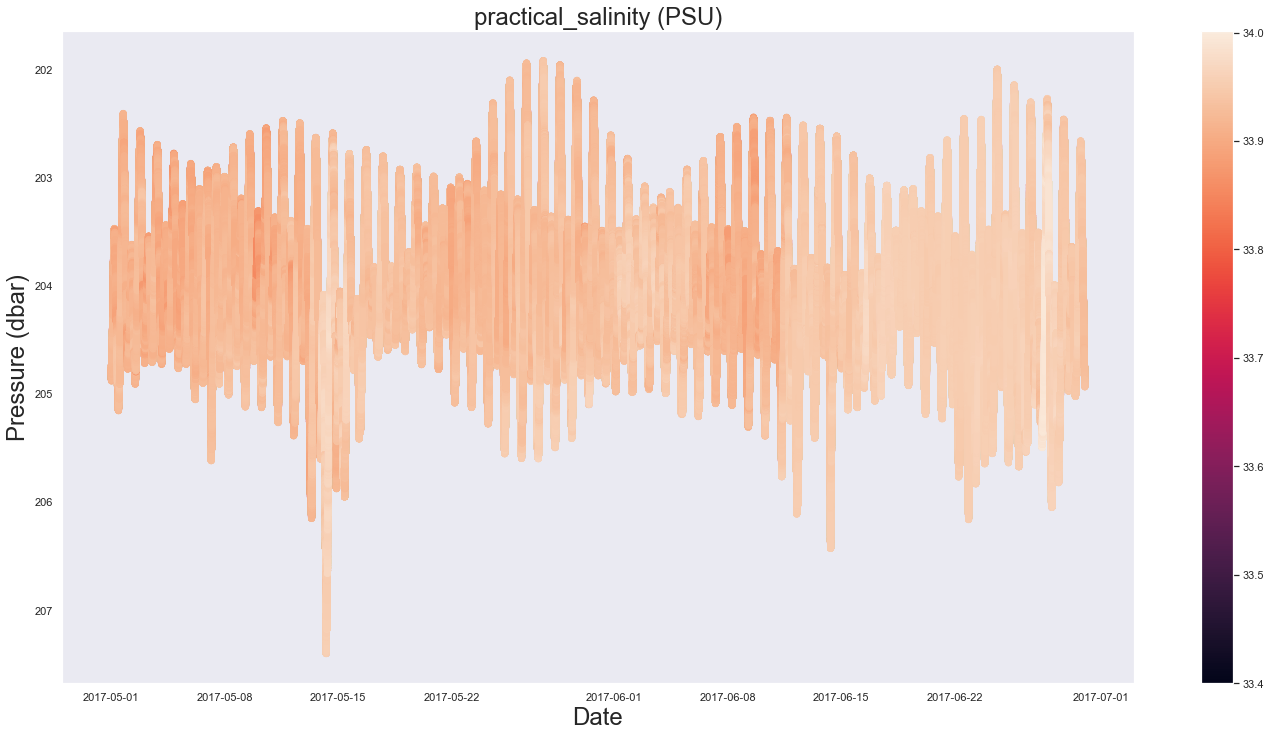

In [114]:
# Now, more complete colored scatter plot, with data plotted
# on a depth vs. time axis.
# source: https://github.com/dgumustel/yodapy/blob/master/examples/yodapy_example_plots.ipynb

fig, ax = plt.subplots(figsize=(24, 12))

# plot temp and salinity curtain plots
ax.invert_yaxis()
ax.grid()
#ax1.set_xlim(CTD_data['time'],CTD_data['time'])
sc = ax.scatter(CTD_summer['time'],CTD_summer['seawater_pressure'],c=CTD_summer['practical_salinity'], vmin=33.4)
ax.set_xlabel('Date', size=24)
ax.set_ylabel('Pressure (dbar)', size=24)
ax.set_title('practical_salinity (PSU)', size=24)
cb = fig.colorbar(sc,ax=ax)

plt.savefig('CTD_profiler_salinity.png')

In [59]:
#METBK_summer_minutes

In [60]:
METBK_summer_minutes = METBK_summer_minutes.rename(columns={'sea_surface_temperature': 'Sea Surface Temperature (deg_C)',
                                            'met_windavg_mag_corr_east': 'Eastward Wind Velocity ({})'.format(METBK_units['met_windavg_mag_corr_east'][0]), 
                                            'met_windavg_mag_corr_north': 'Northward Wind Velocity ({})'.format(METBK_units['met_windavg_mag_corr_north'][0])})

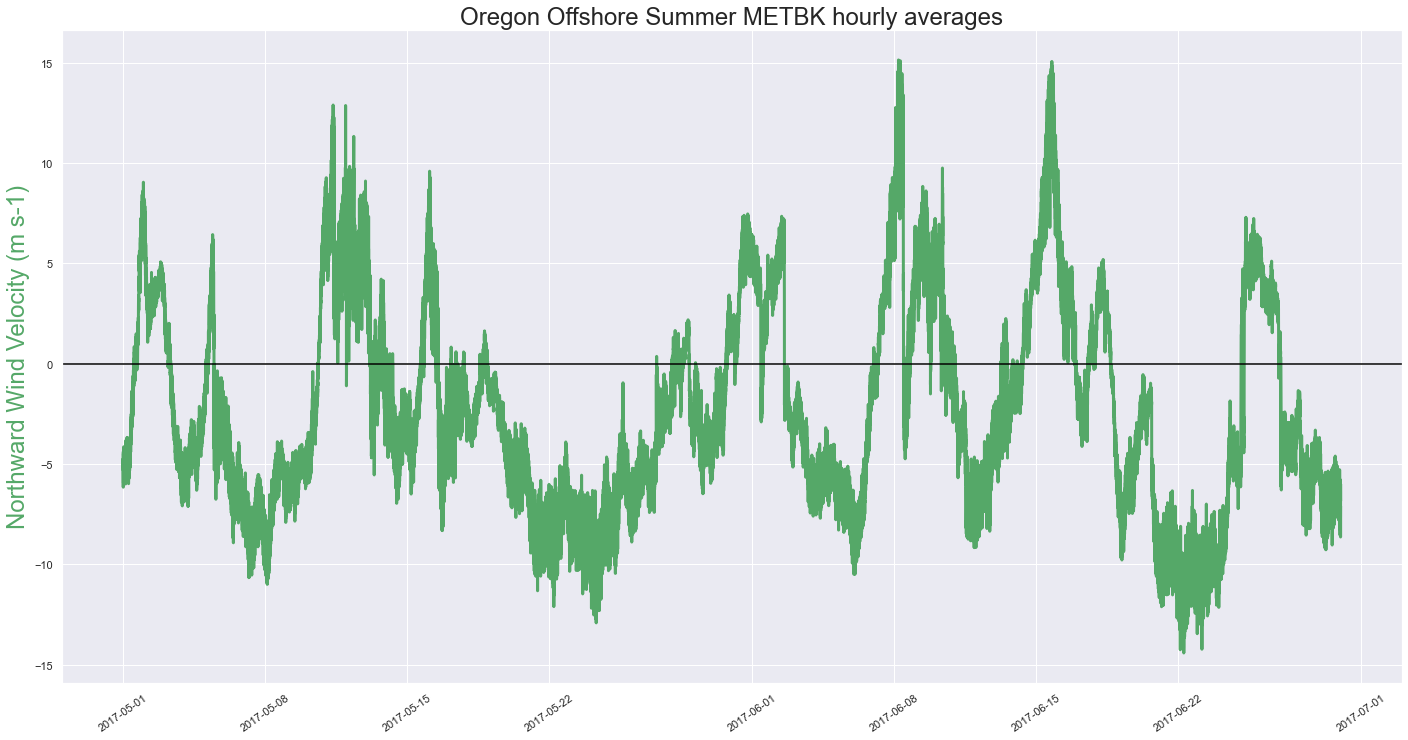

In [61]:
fig, ax = plt.subplots(figsize=(24, 12))
ax.plot(METBK_summer_minutes['time'], METBK_summer_minutes['Northward Wind Velocity (m s-1)'], 'g', linewidth=3)
ax.set_ylabel('Northward Wind Velocity (m s-1)', color='g', size=24)
plt.xticks(rotation=35)

ax.axhline(y=0, ls='-', c='black') # add horizontal line at 0
ax.set_title('Oregon Offshore Summer METBK hourly averages', size=24);

### Next up

Need to add practical salinity to variables that I pull in in order to plot the above with salinity data - this would be nice because seawater temperature and salinity are inversely related, so we expect to see the same pattern in both variables - is this what you see? 

Pull in next: 
* salinity
* dissolved oxygen
* density?
* upwelling index data

---
# Pull in CUTI index data

In [62]:
cuti = pd.read_csv('CUTI_daily.csv')

In [63]:
mask = (cuti['year'] == 2017)
cuti = cuti.loc[mask]

In [64]:
cuti

,year,month,day,31N,32N,33N,34N,35N,36N,37N,38N,39N,40N,41N,42N,43N,44N,45N,46N,47N
10593,2017,1,1,0.304,0.348,0.805,0.904,0.612,0.390,0.712,1.596,1.950,3.470,3.912,2.677,1.937,1.731,0.619,1.463,1.365
10594,2017,1,2,0.684,0.432,0.706,0.877,0.700,0.479,0.424,1.092,1.148,1.376,1.111,1.063,1.066,1.308,0.574,0.625,0.709
10595,2017,1,3,0.443,0.284,0.273,0.055,0.076,0.093,-0.186,-0.121,0.011,-0.014,-0.386,0.296,0.306,0.360,0.418,0.542,-0.171
10596,2017,1,4,0.130,0.124,0.064,-0.031,-0.588,-0.436,-0.878,0.166,0.118,0.052,-0.041,0.423,0.479,0.742,0.694,-0.226,-0.382
10597,2017,1,5,0.023,-0.029,-0.189,-0.134,-0.225,0.126,-0.098,-0.101,0.562,1.107,0.565,0.751,1.013,1.469,1.337,-0.287,-0.294
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10953,2017,12,27,-0.120,0.197,-0.119,-0.043,0.519,1.084,0.554,0.645,0.379,-0.008,0.223,0.465,0.261,0.256,0.101,0.282,-0.061
10954,2017,12,28,0.013,0.048,0.076,0.394,0.055,0.269,0.626,0.410,0.493,0.157,-0.286,0.031,-0.034,0.214,-0.072,-0.110,-0.040
10955,2017,12,29,0.104,-0.038,-0.029,-0.191,0.011,0.814,0.202,-0.814,-0.113,-0.101,-0.475,-0.094,-0.472,-0.814,-1.247,-0.602,-0.099
10956,2017,12,30,-0.061,0.172,0.074,-0.441,-0.289,-0.349,-0.157,0.944,-0.082,-0.726,-0.722,-0.223,-0.458,-0.675,-0.523,-0.272,0.012


In [65]:
cuti['time'] = pd.to_datetime(cuti[['year', 'month', 'day']])

In [66]:
cuti

,year,month,day,31N,32N,33N,34N,35N,36N,37N,...,39N,40N,41N,42N,43N,44N,45N,46N,47N,time
10593,2017,1,1,0.304,0.348,0.805,0.904,0.612,0.390,0.712,...,1.950,3.470,3.912,2.677,1.937,1.731,0.619,1.463,1.365,2017-01-01
10594,2017,1,2,0.684,0.432,0.706,0.877,0.700,0.479,0.424,...,1.148,1.376,1.111,1.063,1.066,1.308,0.574,0.625,0.709,2017-01-02
10595,2017,1,3,0.443,0.284,0.273,0.055,0.076,0.093,-0.186,...,0.011,-0.014,-0.386,0.296,0.306,0.360,0.418,0.542,-0.171,2017-01-03
10596,2017,1,4,0.130,0.124,0.064,-0.031,-0.588,-0.436,-0.878,...,0.118,0.052,-0.041,0.423,0.479,0.742,0.694,-0.226,-0.382,2017-01-04
10597,2017,1,5,0.023,-0.029,-0.189,-0.134,-0.225,0.126,-0.098,...,0.562,1.107,0.565,0.751,1.013,1.469,1.337,-0.287,-0.294,2017-01-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10953,2017,12,27,-0.120,0.197,-0.119,-0.043,0.519,1.084,0.554,...,0.379,-0.008,0.223,0.465,0.261,0.256,0.101,0.282,-0.061,2017-12-27
10954,2017,12,28,0.013,0.048,0.076,0.394,0.055,0.269,0.626,...,0.493,0.157,-0.286,0.031,-0.034,0.214,-0.072,-0.110,-0.040,2017-12-28
10955,2017,12,29,0.104,-0.038,-0.029,-0.191,0.011,0.814,0.202,...,-0.113,-0.101,-0.475,-0.094,-0.472,-0.814,-1.247,-0.602,-0.099,2017-12-29
10956,2017,12,30,-0.061,0.172,0.074,-0.441,-0.289,-0.349,-0.157,...,-0.082,-0.726,-0.722,-0.223,-0.458,-0.675,-0.523,-0.272,0.012,2017-12-30


In [67]:
cuti.describe()

,year,month,day,31N,32N,33N,34N,35N,36N,37N,38N,39N,40N,41N,42N,43N,44N,45N,46N,47N
count,365.0,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.00000,365.000000,365.000000
mean,2017.0,6.526027,15.720548,0.609044,0.461115,0.370507,0.516510,0.656170,0.667649,0.461605,0.458197,0.714452,0.741230,0.382332,0.440364,0.270170,0.044526,-0.00937,0.057104,-0.003732
std,0.0,3.452584,8.808321,0.579076,0.393689,0.430674,0.657754,0.738901,0.848936,0.768430,0.966081,1.177748,1.223045,1.217789,1.314468,1.037623,0.809462,0.84350,0.626244,0.627815
min,2017.0,1.000000,1.000000,-0.726000,-0.417000,-0.490000,-0.773000,-1.498000,-1.727000,-2.417000,-1.801000,-2.599000,-2.642000,-3.154000,-4.413000,-3.946000,-3.996000,-4.58900,-3.085000,-2.992000
25%,2017.0,4.000000,8.000000,0.170000,0.171000,0.091000,0.042000,0.129000,0.100000,0.019000,-0.132000,-0.048000,-0.038000,-0.216000,-0.212000,-0.230000,-0.350000,-0.29700,-0.270000,-0.322000
50%,2017.0,7.000000,16.000000,0.535000,0.398000,0.258000,0.407000,0.504000,0.473000,0.316000,0.250000,0.397000,0.447000,0.223000,0.299000,0.278000,0.105000,0.06900,0.126000,0.069000
75%,2017.0,10.000000,23.000000,0.921000,0.689000,0.517000,0.827000,1.077000,1.106000,0.880000,0.920000,1.275000,1.476000,0.893000,1.142000,0.863000,0.508000,0.48100,0.426000,0.370000
max,2017.0,12.000000,31.000000,2.777000,2.136000,2.152000,3.588000,3.956000,4.986000,5.325000,7.151000,8.001000,6.436000,6.209000,6.505000,4.487000,2.517000,2.18100,1.768000,1.987000


In [68]:
cuti.isna().sum()

year     0
month    0
day      0
31N      0
32N      0
33N      0
34N      0
35N      0
36N      0
37N      0
38N      0
39N      0
40N      0
41N      0
42N      0
43N      0
44N      0
45N      0
46N      0
47N      0
time     0
dtype: int64

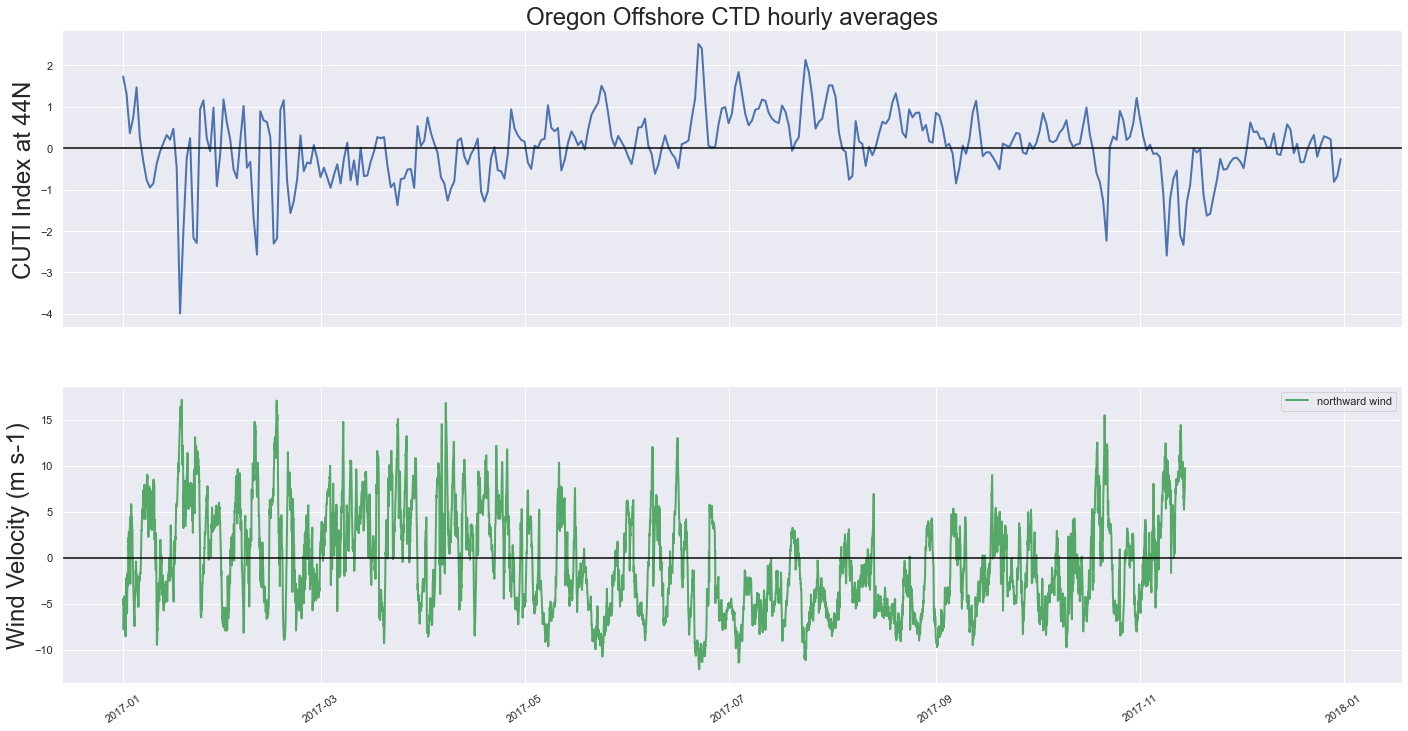

In [75]:
# Plot hourly-averaged METBK data
fig, (ax2, ax1) = plt.subplots(2, 1, sharex=True, figsize=(24, 12))
ax1.plot(cuti['time'], cuti['44N'], 'b', linewidth=2)
ax1.set_xlabel('')
ax1.set_ylabel('CUTI Index at 44N', size=24)
ax1.set_title('Oregon Offshore CTD hourly averages', size=24)
ax1.axhline(y=0, ls='-', c='black') # add horizontal line at 0

#ax2.plot(METBK_hourly['time'], METBK_hourly['Eastward Wind Velocity (m s-1)'], 'c', label='eastward wind')
ax2.plot(METBK_hourly['time'], METBK_hourly['Northward Wind Velocity (m s-1)'], 'g', label='northward wind', linewidth=2)
ax2.set_ylabel('Wind Velocity ({})'.format(METBK_units['met_windavg_mag_corr_north'][0]), size=24)
ax2.legend()
ax2.axhline(y=0, ls='-', c='black') # add horizontal line at 0

plt.xticks(rotation=35);

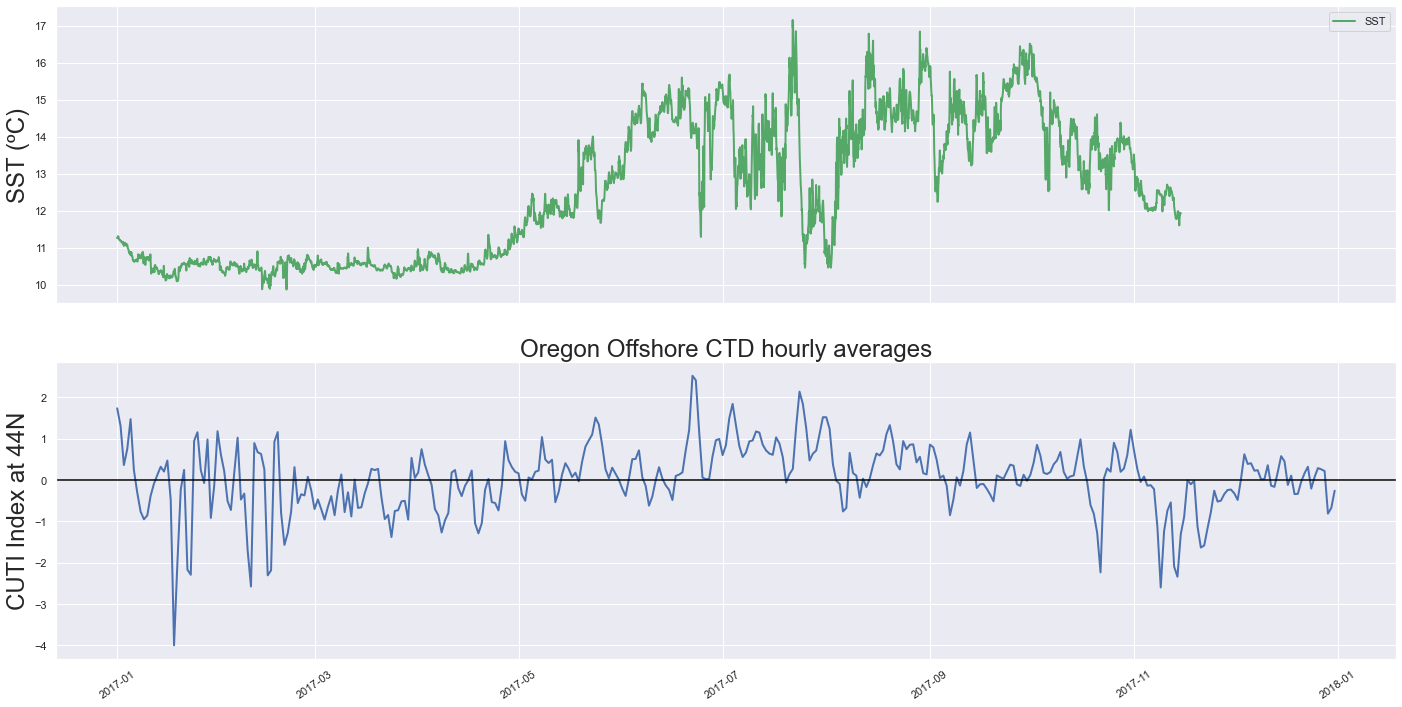

In [81]:
# Plot hourly-averaged METBK data
fig, (ax2, ax1) = plt.subplots(2, 1, sharex=True, figsize=(24, 12))
ax1.plot(cuti['time'], cuti['44N'], 'b', linewidth=2)
ax1.set_xlabel('')
ax1.set_ylabel('CUTI Index at 44N', size=24)
ax1.set_title('Oregon Offshore CTD hourly averages', size=24)
ax1.axhline(y=0, ls='-', c='black') # add horizontal line at 0

#ax2.plot(METBK_hourly['time'], METBK_hourly['Eastward Wind Velocity (m s-1)'], 'c', label='eastward wind')
ax2.plot(METBK_hourly['time'], METBK_hourly['Sea Surface Temperature (deg_C)'], 'g', label='SST', linewidth=2)
ax2.set_ylabel('SST ({})'.format(METBK_units['sea_surface_temperature'][0]), size=24)
ax2.legend()

plt.xticks(rotation=35);

Nice place to explore CUTI data: https://heatherwelch.shinyapps.io/shiny_jacox_cuti/

--- 
### Save data for modeling

**Be careful saving this data!**

It can save a lot of time BUT it's very easy to accidentally overwrite something that you really needed! 

In [55]:
# METBK_data_copy.to_csv('METBK_01-01_12-01.csv', index=False)
# CTD_data_copy.to_csv('CTD_01-01_09-16.csv', index=False)

List of dataframes created here: 

'CTD_daily',
'CTD_data',
'CTD_data_copy',
'CTD_hourly',
'CTD_minutes',
'CTD_summer',
'CTD_summer_minutes',
'CTD_week',


'METBK_daily',
'METBK_data',
'METBK_data_copy',
'METBK_hourly',
'METBK_minutes',
'METBK_summer_data',
'METBK_summer_minutes'

In [122]:
CTD_five_minutes = CTD_data.resample('5T', on='time').mean().dropna(how='all').reset_index()
METBK_five_minutes = METBK_data_copy.resample('5T', on='time').mean().dropna(how='all').reset_index()

In [123]:
METBK_five_minutes

,time,sea_surface_temperature,met_windavg_mag_corr_east,met_windavg_mag_corr_north
0,2017-01-01 00:00:00,11.2706,4.508827e+00,-5.379293e+00
1,2017-01-01 00:05:00,11.2734,3.565842e+00,-5.104888e+00
2,2017-01-01 00:10:00,11.2684,4.480898e+00,-4.276227e+00
3,2017-01-01 00:15:00,11.2688,4.445523e+00,-4.517499e+00
4,2017-01-01 00:20:00,11.2664,3.978126e+00,-4.948819e+00
...,...,...,...,...
96408,2017-12-01 18:10:00,12.0454,-1.228042e+07,-7.013654e+06
96409,2017-12-01 18:15:00,12.0476,-1.228042e+07,-7.013654e+06
96410,2017-12-01 18:20:00,12.0498,-1.228042e+07,-7.013654e+06
96411,2017-12-01 18:25:00,12.0526,-1.228042e+07,-7.013654e+06


In [125]:
CTD_five_minutes

,time,seawater_pressure,practical_salinity,seawater_temperature,corrected_dissolved_oxygen,lat,lon
0,2017-01-01 00:00:00,200.443063,33.887095,7.782278,106.538309,44.37415,-124.95648
1,2017-01-01 00:05:00,200.390905,33.887016,7.783830,106.473931,44.37415,-124.95648
2,2017-01-01 00:10:00,200.341566,33.887443,7.783282,106.329082,44.37415,-124.95648
3,2017-01-01 00:15:00,200.300686,33.887857,7.781079,106.232525,44.37415,-124.95648
4,2017-01-01 00:20:00,200.246572,33.890147,7.763354,105.977270,44.37415,-124.95648
...,...,...,...,...,...,...,...
71742,2017-09-16 11:50:00,269.405700,33.965714,7.227581,85.537419,44.37415,-124.95648
71743,2017-09-16 11:55:00,201.202692,33.924119,7.880886,97.002159,44.37415,-124.95648
71744,2017-09-16 12:00:00,97.638500,33.738392,9.066732,143.117259,44.37415,-124.95648
71745,2017-09-16 12:05:00,49.993728,33.371898,10.085181,186.610283,44.37415,-124.95648


In [116]:
ds_list = [CTD_daily, CTD_data, CTD_data_copy, CTD_hourly, CTD_minutes, 
            CTD_summer, CTD_summer_minutes, CTD_week, CTD_five_minutes, 
            METBK_daily, METBK_data, METBK_data_copy, METBK_hourly, METBK_minutes, 
            METBK_summer_data, METBK_summer_minutes, METBK_five_minutes]

for ds in ds_list:
    print(ds.shape)

(253, 7)
(21517483, 7)
(21517483, 7)
(5984, 7)
(358673, 7)
(5182339, 7)
(86384, 7)
(431988, 7)
(71747, 7)
(318, 4)
(460984, 4)
(485137, 4)
(7632, 4)
(427289, 4)
(2208, 4)
(81224, 4)
(91582, 4)


In [126]:
# CTD_daily.to_csv('CTD_daily.csv', index=False)
# METBK_daily.to_csv('METBK_daily.csv', index=False)

In [124]:
# CTD_five_minutes.to_csv('CTD_five_minutes.csv', index=False)
# METBK_five_minutes.to_csv('METBK_five_minutes.csv', index=False)

In [128]:
# cuti.to_csv('cuti.csv', index=False)

In [107]:
# dir()

In [ ]:
# METBK_hourly.to_csv('METBK_03-01_06_30.csv', index=False)
# CTD_data.to_csv('CTD_03-01_06_30.csv', index=False)

Reevaluate all the dataframes I've made here and choose which ones I want to carry over to the modeling.

In [131]:
CTD_data['seawater_pressure'].describe()

count    2.151748e+07
mean     1.892278e+02
std      3.956323e+01
min      1.355533e+01
25%      2.026819e+02
50%      2.037541e+02
75%      2.044697e+02
max      2.906436e+02
Name: seawater_pressure, dtype: float64